In [1]:
import numpy as np
import projectLib as lib
import matplotlib.pyplot as plt

# set highest rating
K = 5
F = 3
eps=0.1

def softmax(x):
    # Numerically stable softmax function
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def ratingsPerMovie(training):
    movies = [x[0] for x in training]
    u_movies = np.unique(movies).tolist()
    return np.array([[i, movie, len([x for x in training if x[0] == movie])] for i, movie in enumerate(u_movies)])

def getV(ratingsForUser):
    # ratingsForUser is obtained from the ratings for user library
    # you should return a binary matrix ret of size m x K, where m is the number of movies
    #   that the user has seen. ret[i][k] = 1 if the user
    #   has rated movie ratingsForUser[i, 0] with k stars
    #   otherwise it is 0
    ret = np.zeros((len(ratingsForUser), K))
    for i in range(len(ratingsForUser)):
        ret[i, ratingsForUser[i, 1]-1] = 1.0
    return ret

def getInitialWeights(m, F, K):
    # m is the number of visible units
    # F is the number of hidden units
    # K is the highest rating (fixed to 5 here)
    return np.random.normal(0, 0.1, (m, F, K))

In [2]:
training = lib.getTrainingData()
ratingsForUser1 = lib.getRatingsForUser(1, training)

In [3]:
# ratingsPerMovie(training)
v = getV(ratingsForUser1)
# v.shape
w = getInitialWeights(v.shape[0],F,5)

In [4]:
trStats = lib.getUsefulStats(training)
W = getInitialWeights(trStats["n_movies"], F, K)

In [5]:
def sig(x):
    ### TO IMPLEMENT ###
    # x is a real vector of size n
    # ret should be a vector of size n where ret_i = sigmoid(x_i)
    return 1/(1+np.exp(-x))

def visibleToHiddenVec(v, w):
    ### TO IMPLEMENT ###
    # v is a matrix of size m x 5. Each row is a binary vector representing a rating
    #    OR a probability distribution over the rating
    # w is a list of matrices of size m x F x 5
    # ret should be a vector of size F
    m,f,K=w.shape
    output=list()
    for i in range(f):
        summ=0
        for k in range(K):
            for j in range(m):
                summ+=v[j,k]*w[j,i,k]
        output.append(summ)
    return sig(np.array(output))
    

def hiddenToVisible(h, w):
    ### TO IMPLEMENT ###
    # h is a binary vector of size F
    # w is an array of size m x F x 5
    # ret should be a matrix of size m x 5, where m
    #   is the number of movies the user has seen.
    #   Remember that we do not reconstruct movies that the user
    #   has not rated! (where reconstructing means getting a distribution
    #   over possible ratings).
    #   We only do so when we predict the rating a user would have given to a movie.
#     print(w.shape)
    output=w[:,0,:]*h[0]
    m,f,k=w.shape
    for i in range(1,f):
        output+=w[:,i,:]*h[i]
    return sig(output)

def probProduct(v, p):
    # v is a matrix of size m x 5
    # p is a vector of size F, activation of the hidden units
    # returns the gradient for visible input v and hidden activations p
    ret = np.zeros((v.shape[0], p.size, v.shape[1]))
    for i in range(v.shape[0]):
        for j in range(p.size):
            for k in range(v.shape[1]):
                ret[i, j, k] = v[i, k] * p[j]
    return ret

def sample(p):
    # p is a vector of real numbers between 0 and 1
    # ret is a vector of same size as p, where ret_i = Ber(p_i)
    # In other word we sample from a Bernouilli distribution with
    # parameter p_i to obtain ret_i
    samples = np.random.random(p.size)
    return np.array(samples <= p, dtype=int)

def getPredictedDistribution(v, w, wq):
    ### TO IMPLEMENT ###
    # This function returns a distribution over the ratings for movie q, if user data is v
    # v is the dataset of the user we are predicting the movie for
    #   It is a m x 5 matrix, where m is the number of movies in the
    #   dataset of this user.
    # w is the weights array for the current user, of size m x F x 5
    # wq is the weight matrix of size F x 5 for movie q
    #   If W is the whole weights array, then wq = W[q, :, :]
    # You will need to perform the same steps done in the learning/unlearning:
    #   - Propagate the user input to the hidden units
    #   - Sample the state of the hidden units
    #   - Backpropagate these hidden states to obtain
    #       the distribution over the movie whose associated weights are wq
    # ret is a vector of size 5
    m,f,K=w.shape
    p_learn = visibleToHiddenVec(v,w)
    PG = probProduct(v, p_learn)
    hidden_activations = sample(p_learn)
#     print(hidden_activations)
    v_negative = hiddenToVisible(hidden_activations, wq.reshape(1,wq.shape[0],wq.shape[1]))
#     p_unlearn = visibleToHiddenVec(v_negative, w)
#     NG = probProduct(v_negative, p_unlearn)
# #     print(eps*(PG-NG))
# #     print (w.shape)
#     w += eps*(PG-NG)
    return v_negative.reshape(5)

def predictRatingMax(ratingDistribution):
    ### TO IMPLEMENT ###
    # ratingDistribution is a probability distribution over possible ratings
    #   It is obtained from the getPredictedDistribution function
    # This function is one of three you are to implement
    # that returns a rating from the distribution
    # We decide here that the predicted rating will be the one with the highest probability
    result = np.where(ratingDistribution == np.amax(ratingDistribution))[0].item()
    return result+1

def predictRatingMean(ratingDistribution):
    ### TO IMPLEMENT ###
    # ratingDistribution is a probability distribution over possible ratings
    #   It is obtained from the getPredictedDistribution function
    # This function is one of three you are to implement
    # that returns a rating from the distribution
    # We decide here that the predicted rating will be the expectation over ratingDistribution
    normalized = ratingDistribution/sum(ratingDistribution)
    result = 0 
    for k in range(ratingDistribution.shape[0]):
        result += normalized[k]*(k+1)
    return result

def predictRatingExp(ratingDistribution):
    ### TO IMPLEMENT ###
    # ratingDistribution is a probability distribution over possible ratings
    #   It is obtained from the getPredictedDistribution function
    # This function is one of three you are to implement
    # that returns a rating from the distribution
    # We decide here that the predicted rating will be the expectation over
    # the softmax applied to ratingDistribution
    softmax = np.exp(ratingDistribution)/sum(np.exp(ratingDistribution))
#     print(softmax)
    result = 0 
    for k in range(len(ratingDistribution)):
        result += softmax[k]*(k+1)
#         print (result)
    return result

def predictMovieForUser(q, user, W, training, predictType="exp"):
    # movie is movie idx
    # user is user ID
    # type can be "max" or "exp"
    ratingsForUser = lib.getRatingsForUser(user, training)
    v = getV(ratingsForUser)
#     print(np.where(ratingsForUser[:,0]==q))
    ratingDistribution = getPredictedDistribution(v, W[ratingsForUser[:, 0], :, :], W[q, :, :])#[np.where(ratingsForUser[:,0]==q)[0][0]]
    if predictType == "max":
        return predictRatingMax(ratingDistribution)
    elif predictType == "mean":
        return predictRatingMean(ratingDistribution)
    else:
        return predictRatingExp(ratingDistribution)

def predict(movies, users, W, training, predictType="exp"):
    # given a list of movies and users, predict the rating for each (movie, user) pair
    # used to compute RMSE
    return [predictMovieForUser(movie, user, W, training, predictType=predictType) for (movie, user) in zip(movies, users)]

def predictForUser(user, W, training, predictType="exp"):
    ### TO IMPLEMENT
    # given a user ID, predicts all movie ratings for the user
    
    return None


In [6]:
q = np.random.choice(ratingsForUser1[:, 0])
index = np.where(ratingsForUser1[:, 0]==q)[0].item()
ratingdist1 = getPredictedDistribution(v, W[ratingsForUser1[:, 0], :, :], W[q, :, :])#[index]
print(ratingdist1)
predictRatingExp(ratingdist1)
# Problem remains - we need the index to know which movie to take the values from in the 
# getPredictedDistribution function. Need to check with TA and clarify that part.

[0.50776175 0.46670562 0.56054473 0.53496917 0.49317229]


3.0077258795219532

In [7]:
def predictForUser(user, W, training, predictType="exp"):
    ### TO IMPLEMENT
    # given a user ID, predicts all movie ratings for the user
    ratingsForUser = lib.getRatingsForUser(user, training)
    v = getV(ratingsForUser)
    ratings = []
    for i in range(np.shape(ratingsForUser)[0]):
        ratingDistribution = getPredictedDistribution(v, W[ratingsForUser[:, 0], :, :], W[ratingsForUser[:,0][i], :, :])[i]
#         print(ratingDistribution)
#     return v
#     ratingDistribution = getPredictedDistribution(v, W[ratingsForUser[:, 0], :, :], )
        if predictType == "max":
            ratings.append(predictRatingMax(ratingDistribution))
        elif predictType == "mean":
            ratings.append(predictRatingMean(ratingDistribution))
        else:
#             print (predictRatingExp(ratingDistribution))
            ratings.append(predictRatingExp(ratingDistribution))
    return ratings

### EPOCH 1 ###
Training loss = 1.183755
Validation loss = 1.212678
### EPOCH 2 ###
Training loss = 1.186937
Validation loss = 1.217097
### EPOCH 3 ###
Training loss = 1.178021
Validation loss = 1.219165
### EPOCH 4 ###
Training loss = 1.170068
Validation loss = 1.217960
### EPOCH 5 ###
Training loss = 1.159438
Validation loss = 1.212322
### EPOCH 6 ###
Training loss = 1.154434
Validation loss = 1.207870
### EPOCH 7 ###
Training loss = 1.145108
Validation loss = 1.206523
### EPOCH 8 ###
Training loss = 1.137240
Validation loss = 1.207257
### EPOCH 9 ###
Training loss = 1.131020
Validation loss = 1.205350
### EPOCH 10 ###
Training loss = 1.125436
Validation loss = 1.203253
### EPOCH 11 ###
Training loss = 1.119109
Validation loss = 1.194919
### EPOCH 12 ###
Training loss = 1.116979
Validation loss = 1.200775
### EPOCH 13 ###
Training loss = 1.112438
Validation loss = 1.203474
### EPOCH 14 ###
Training loss = 1.108987
Validation loss = 1.204882
### EPOCH 15 ###
Training loss = 1.105606
V

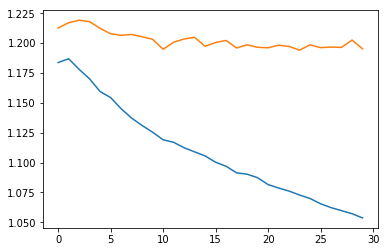

In [9]:
import numpy as np
import rbm
import projectLib as lib

training = lib.getTrainingData()
validation = lib.getValidationData()
# You could also try with the chapter 4 data
# training = lib.getChapter4Data()

trStats = lib.getUsefulStats(training)
vlStats = lib.getUsefulStats(validation)

K = 5
alpha = 0.9

# SET PARAMETERS HERE!!!
# number of hidden units
F = 20
epochs = 30
gradientLearningRate = 0.0001
_lambda = 1

# Initialise all our arrays
W = getInitialWeights(trStats["n_movies"], F, K)
posprods = np.zeros(W.shape)
negprods = np.zeros(W.shape)
m=np.zeros((97,F,5))
train_loss = []
validation_loss = []

for epoch in range(1, epochs+1):
    # in each epoch, we'll visit all users in a random order
    visitingOrder = np.array(trStats["u_users"])
    np.random.shuffle(visitingOrder)

    for user in visitingOrder:
        # get the ratings of that user
        ratingsForUser = lib.getRatingsForUser(user, training)

        # build the visible input
        v = getV(ratingsForUser)

        # get the weights associated to movies the user has seen
        weightsForUser = W[ratingsForUser[:, 0], :, :]

        ### LEARNING ###
        # propagate visible input to hidden units
        posHiddenProb = visibleToHiddenVec(v, weightsForUser)
        # get positive gradient
        # note that we only update the movies that this user has seen!
        posprods[ratingsForUser[:, 0], :, :] += probProduct(v, posHiddenProb)

        ### UNLEARNING ###
        # sample from hidden distribution
        sampledHidden = sample(posHiddenProb)
        # propagate back to get "negative data"
        negData = hiddenToVisible(sampledHidden, weightsForUser)
        # propagate negative data to hidden units
        negHiddenProb = visibleToHiddenVec(negData, weightsForUser)
        # get negative gradient
        # note that we only update the movies that this user has seen!
        negprods[ratingsForUser[:, 0], :, :] += probProduct(negData, negHiddenProb)

        # we average over the number of users in the batch (if we use mini-batch)
        grad = (gradientLearningRate/epoch) * (posprods - negprods)
        
        m = alpha*m+grad

        W += m

    # Print the current RMSE for training and validation sets
    # this allows you to control for overfitting e.g
    # We predict over the training set
    tr_r_hat = predict(trStats["movies"], trStats["users"], W, training)
#     print (tr_r_hat)
    trRMSE = lib.rmse(trStats["ratings"], tr_r_hat)
#     print (trRMSE)

    # We predict over the validation set
    vl_r_hat = predict(vlStats["movies"], vlStats["users"], W, training)
#     vl_r_hat
    vlRMSE = lib.rmse(vlStats["ratings"], vl_r_hat)
    
    train_loss.append(trRMSE)
    validation_loss.append(vlRMSE)

    print ("### EPOCH %d ###" % epoch)
    print ("Training loss = %f" % trRMSE)
    print ("Validation loss = %f" % vlRMSE)

### END ###
# This part you can write on your own
# you could plot the evolution of the training and validation RMSEs for example
# predictedRatings = np.array([predictForUser(user, W, training) for user in trStats["u_users"]])
# np.savetxt("predictedRatings.txt", predictedRatings)
# fig1 = plt.figure()
# ax1 = fig1.add_subplot(121)
# ax1.plot(train_loss)
# ax2 = fig1.add_subplot(122)
# ax2.plot(validation_loss)

plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()

In [ ]:
np.shape(posprods)

In [ ]:
vlStats["users"]

In [ ]:
min(vl_r_hat)

In [ ]:
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()